In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm


df1=pd.read_csv('./data/Shanghai Composite Historical Data.csv')
print(df1.columns)
df1=pd.DataFrame({
    'Data':df1.Date.values[::-1],
    'Price':[float(i.replace(',','')) for i in df1['Price'].values][::-1],
    'Open':[float(i.replace(',','')) for i in df1['Open'].values][::-1],
    'High':[float(i.replace(',','')) for i in df1['High'].values][::-1],
    'Low':[float(i.replace(',','')) for i in df1['Low'].values][::-1]
                  })
df1


Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


,Data,Price,Open,High,Low
0,11/01/2022,2969.20,2899.50,2969.20,2896.76
1,11/02/2022,3003.37,2960.65,3019.05,2954.95
2,11/03/2022,2997.81,2981.20,3003.72,2977.72
3,11/04/2022,3070.80,2997.00,3081.59,2997.00
4,11/07/2022,3077.82,3062.86,3088.19,3054.46
...,...,...,...,...,...
242,10/31/2023,3018.77,3019.65,3023.00,3006.61
243,11/01/2023,3023.08,3038.18,3038.33,3013.93
244,11/02/2023,3009.41,3028.66,3038.64,3009.12
245,11/03/2023,3030.80,3012.47,3040.98,3012.47


In [2]:
#Params
time_window = 14
pred_window=7

BATCH_SIZE=16
nums_layer=1
lr=5e-4
test_size=0.2
N_epoch=100
device = torch.device('mps')

Price_data2=df1['Price'].values.reshape(-1,1)

scaler1=MinMaxScaler()
Price_data=scaler1.fit_transform(Price_data2).reshape(-1)
print(Price_data.shape)

data_his=[]
data_pred=[]
for i in range(len(Price_data)-time_window-pred_window):
    data_his.append(np.array(Price_data[i:i+time_window]))
    data_pred.append(np.array(Price_data[i+time_window:i+time_window+pred_window]))

print(data_his[0],data_pred[0])
print(len(data_his),len(data_pred))

(247,)
[0.06563385 0.14061574 0.128415   0.28858265 0.30398718 0.27473613
 0.23892388 0.21250357 0.32476794 0.31623181 0.42744289 0.39650216
 0.38651774 0.34660201] [0.31983059 0.32838867 0.34587786 0.32920059 0.35636699 0.30558908
 0.46182879]
226 226


In [3]:
data_his=np.array(data_his)
data_pred=np.array(data_pred)



print(data_his.shape,data_pred.shape)

Train_x,Train_y=data_his[:-int(test_size*len(data_his))],data_pred[:-int(test_size*len(data_his))]
Test_x,Test_y=data_his[-int(test_size*len(data_his)):],data_pred[-int(test_size*len(data_his)):]
print(Train_x.shape,Train_y.shape,Test_x.shape,Test_y.shape)

class TimeDataset(Dataset):
    def __init__(self,df_x,df_y):
        self.data=df_x
        self.label=df_y
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        data_value=torch.FloatTensor(self.data[index,:])
        label_value=torch.FloatTensor([self.label[index]])
        return data_value,label_value.view(-1)

train_dataset=TimeDataset(df_x=Train_x,df_y=Train_y)
valid_dataset=TimeDataset(df_x=Test_x,df_y=Test_y)
train_iterator=DataLoader(train_dataset,batch_size=BATCH_SIZE)
valid_iterator=DataLoader(valid_dataset,batch_size=BATCH_SIZE)
#test
for (data,label) in train_iterator:
    print(data.shape)
    print(label.shape)
    break


(226, 14) (226, 7)
(181, 14) (181, 7) (45, 14) (45, 7)
torch.Size([16, 14])
torch.Size([16, 7])


/var/folders/65/s4c34gg17dgbvj0pj8g_hvmw0000gn/T/ipykernel_99151/682025618.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/torch/csrc/utils/tensor_new.cpp:248.)
  label_value=torch.FloatTensor([self.label[index]])


In [4]:
class FCN(nn.Module):
    def __init__(self,InputDim=14,OutputDim=7,nums_layer=6):
        super().__init__()
        layers=[]
        for i in range(nums_layer):
            layers+=[nn.Linear(4096,4096),
                     nn.LeakyReLU(),
                     nn.Linear(4096,4096)
                     ]
        self.layer1=nn.Sequential(
            nn.Linear(InputDim, 4096),
            nn.LeakyReLU(),
        )
        self.layer2=nn.Sequential(*layers)
        self.layer3=nn.Sequential(
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(4096,64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32,out_features=OutputDim),

        )

    def forward(self,data):
        x=self.layer1(data)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

def train(model, iterator, optimizer, criterion,device='cpu'):
    epoch_loss = 0
    model=model.to(device)
    model.train()
    for batch in iterator:
        batch[0]=batch[0].to(device)
        batch[1]=batch[1].to(device)
        criterion=criterion.to(device)
        optimizer.zero_grad()
        predictions = model(batch[0])

        loss = criterion(predictions, batch[1])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator,criterion,device='cpu'):
    epoch_loss = 0
    model=model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            batch[0]=batch[0].to(device)
            batch[1]=batch[1].to(device)
            criterion=criterion.to(device)
            predictions = model(batch[0])
            loss = criterion(predictions, batch[1])
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

lossfunction=nn.MSELoss()
fc_model=FCN(InputDim=time_window,OutputDim=pred_window,nums_layer=nums_layer)
# fc_model=FullyConnectedModel()
optimizer=torch.optim.Adam(fc_model.parameters(),lr=lr)


In [5]:
train_loss_list=[]
valid_loss_list=[]

par=tqdm(range(N_epoch))

for i in par:
    train_loss=train(model=fc_model,iterator=train_iterator,criterion=lossfunction,optimizer=optimizer,device=device)
    valid_loss=evaluate(model=fc_model,iterator=valid_iterator,criterion=lossfunction,device=device)
    # print("Epoch:{}".format(i+1))
    # print("Training Loss:{:.4f}".format(train_loss),"Valid Loss:{:.4f}".format(valid_loss))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    if i ==0:
        best_valid_loss=valid_loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # print('Save Model..')
        par.set_description_str("Epoch:{}".format(i+1)+' Save!')
        torch.save(fc_model.state_dict(), './result/fc_model.pt')
    else:
        par.set_description_str("Epoch:{}".format(i+1))

    par.set_postfix_str("Training Loss:{:.4f}".format(train_loss)+" Valid Loss:{:.4f}".format(valid_loss))


Epoch:100: 100%|██████████| 100/100 [00:32<00:00,  3.10it/s, Training Loss:0.0105 Valid Loss:0.0290]    


In [6]:
fc_model.load_state_dict(torch.load('./result/fc_model.pt',map_location='cpu'))
fc_model.to('cpu')
train_iterator=DataLoader(train_dataset,batch_size=1)
valid_iterator=DataLoader(valid_dataset,batch_size=1)
list1=[]
list2=[]
real_y_1=[]
real_y_2=[]

with torch.no_grad():
    for batch in train_iterator:
        data=batch[0].to('cpu')
        pre1=fc_model(data)[0][0]
        list1.append(pre1)
        real_y_1.append(batch[1].to('cpu')[0][0])

    for batch in valid_iterator:
         data=batch[0].to('cpu')
         pre2=fc_model(data)[0][0]
         list2.append(pre2)
         real_y_2.append(batch[1].to('cpu')[0][0])

list2=np.array([i.detach().numpy() for i in list2]).reshape(-1)
list1=np.array([i.detach().numpy() for i in list1]).reshape(-1)
real_y_1=np.array([i.detach().numpy() for i in real_y_1]).reshape(-1)
real_y_2=np.array([i.detach().numpy() for i in real_y_2]).reshape(-1)

In [7]:
list1


array([0.26346624, 0.2876467 , 0.30284715, 0.3359353 , 0.3564263 ,
       0.36660945, 0.35115457, 0.44017076, 0.48314124, 0.49007493,
       0.456733  , 0.5331935 , 0.56012666, 0.5624846 , 0.56310517,
       0.52432513, 0.48295468, 0.44786954, 0.46226448, 0.40215182,
       0.43406785, 0.32387906, 0.2565397 , 0.22749789, 0.24281533,
       0.24410267, 0.26815528, 0.28918326, 0.29269946, 0.29092795,
       0.31173623, 0.36389852, 0.3914885 , 0.4653147 , 0.5046182 ,
       0.5501953 , 0.5458297 , 0.5349574 , 0.526135  , 0.55561215,
       0.6403179 , 0.66537154, 0.66808504, 0.6541086 , 0.6963531 ,
       0.70528144, 0.67948836, 0.69991225, 0.6872225 , 0.6594778 ,
       0.6218727 , 0.62754744, 0.61792994, 0.72810113, 0.724831  ,
       0.77101964, 0.7873837 , 0.78037363, 0.7376496 , 0.69616747,
       0.8044976 , 0.8412872 , 0.82543117, 0.7801045 , 0.7465829 ,
       0.71390164, 0.8001871 , 0.8686239 , 0.8669244 , 0.86779433,
       0.831727  , 0.78972197, 0.7948805 , 0.83911175, 0.75119

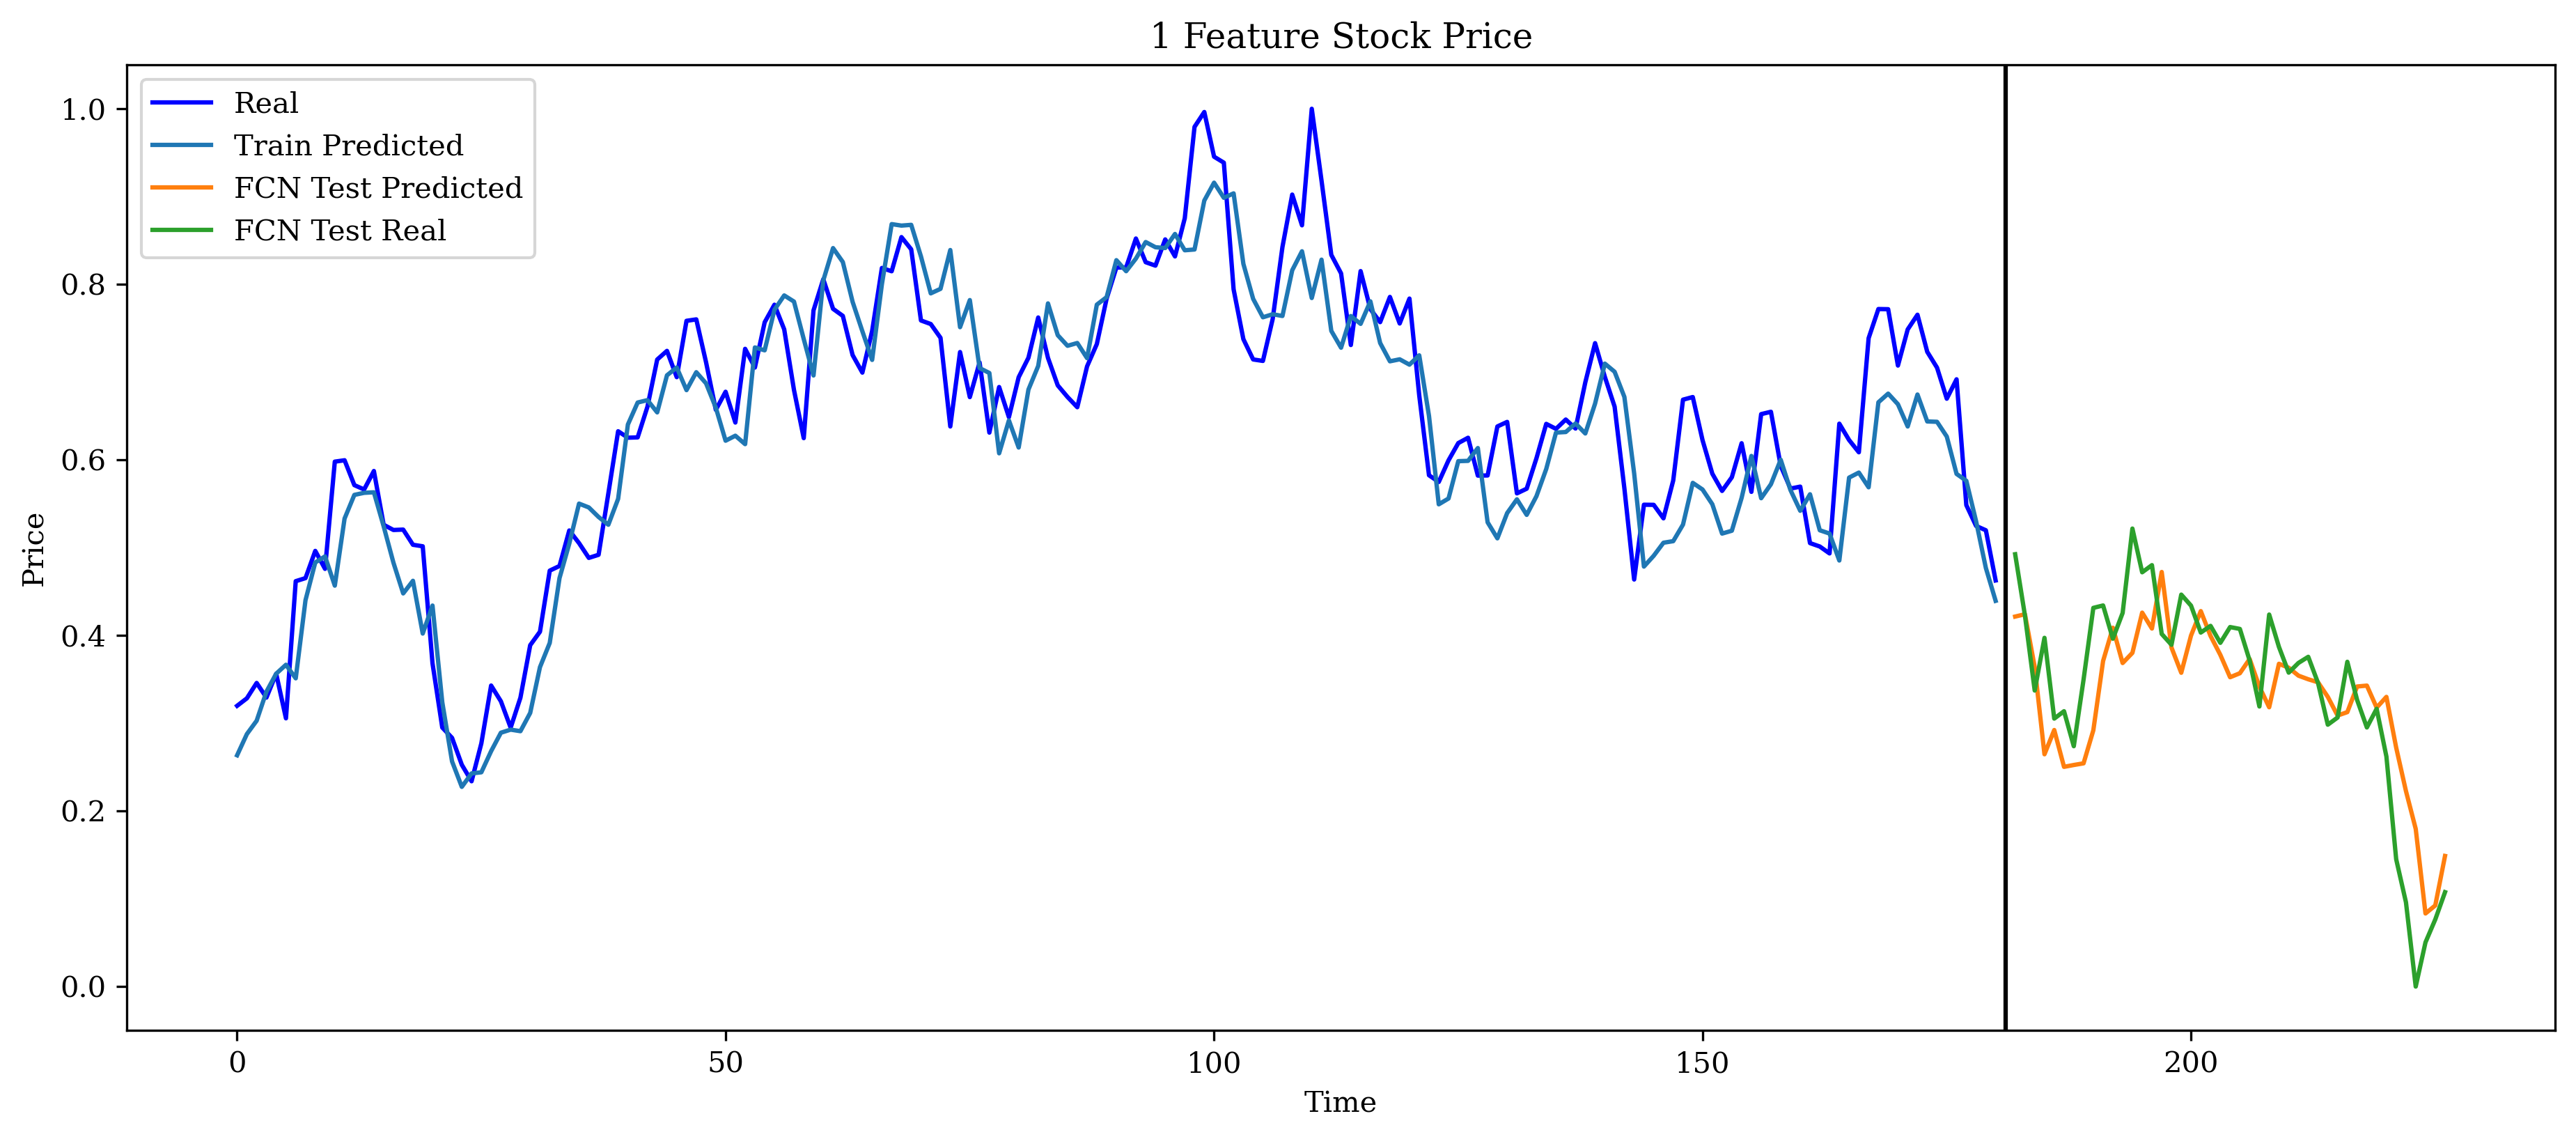

In [8]:
plt.rcParams['font.family']='serif'
plt.figure(figsize=(15,6),dpi=300)
plt.title('1 Feature Stock Price')
plt.plot(range(len(real_y_1)),real_y_1,color='blue',label='Real')
plt.plot(range(len(list1)),list1,label='Train Predicted')
plt.plot(range(len(real_y_1)+1,len(real_y_1)+len(list2)+1),list2,label='FCN Test Predicted')
plt.plot(range(len(real_y_1)+1,len(real_y_1)+len(list2)+1),real_y_2,label='FCN Test Real')
# plt.plot(range(len(Y_train_p)+1,len(Y_train_p)+len(Yvalidation)+1),Yvalidation)
# plt.plot(validation.index,pd.DataFrame(LSTM_pred),color='red',label='LSTM Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.axvline(len(real_y_1),color='black')
plt.legend(loc = "upper left")
plt.savefig('./result/1 Feature Prediction.jpg')